# Basketball Noodling

In [30]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from bs4 import BeautifulSoup
import re

In [31]:
file_path = "/Users/rory/data/ncaa_stats/5731718_box_score.html"
with open(file_path, "r") as file:
    html_content = file.read()

In [32]:
# Assume `html_content` is the HTML content from the page
soup = BeautifulSoup(html_content, "html.parser")

# Updated regex pattern for the specific `addShot` format you provided
shot_data_pattern = re.compile(
    r"addShot\(\s*([\d.]+),\s*([\d.]+),\s*(\d+),\s*(true|false),\s*(\d+),\s*'([^']+)',\s*'([^']+)',\s*(true|false)\s*\);"
)

shot_data = []

for script in soup.find_all("script"):
    if script.string and shot_data_pattern.search(script.string):
        for match in shot_data_pattern.findall(script.string):
            # Map matched groups to relevant fields
            shot = {
                "x": float(match[0]),  # X-coordinate
                "y": float(match[1]),  # Y-coordinate
                "team_id": int(match[2]),  # Team ID
                "made": match[3] == "true",  # Shot success (True if 'made')
                "player_id": int(match[4]),  # Player ID
                "description": match[5],  # Shot description
                "meta_info": match[6],  # Additional metadata
                "flag": match[7] == "true",  # Extra boolean flag, if needed
            }
            shot_data.append(shot)


# Extract teams and players from the dropdowns
teams = {}
for option in soup.select("#team_select option"):
    if option.get("value").isdigit():
        teams[int(option["value"])] = option.text.strip()

players = {}
for optgroup in soup.select("#player_select optgroup"):
    team = optgroup.get("label")
    players[team] = {
        int(option["value"]): option.text.strip()
        for option in optgroup.find_all("option")
    }

# Print results
# print("Shot Data:", shot_data)
print("Teams:", teams)
print("Players by Team:", players)

Teams: {157: 'Colorado', 811: 'Wyoming'}
Players by Team: {'Wyoming': {775989912: 'Allyson Fertig', 775989910: 'Emily Mellema', 775989909: 'Malene Pedersen', 775989908: 'Ola Ustowska', 775989911: 'Tess Barnes', 775989915: 'Kati Ollilainen', 775989917: 'Logann Alvar', 775989916: 'Madi Symons', 775989914: 'Mikyn Hamlin', 775989913: 'Payton Muma'}, 'Colorado': {775989925: 'Jade Masogayo', 775989924: 'Kindyll Wetta', 775989921: 'Lior Garzon', 775989920: 'Nyamer Diew', 775989928: 'Tabitha Betson', 775989927: 'Ayianna Johnson', 775989922: 'Johanna Teder', 775989926: 'Kennedy Sanders', 775989923: 'Sara-Rose Smith'}}


In [33]:
shot_data

[{'x': 91.0,
  'y': 43.0,
  'team_id': 157,
  'made': False,
  'player_id': 2680563039,
  'description': '1st 09:39:00 : missed by Nyamer Diew(Colorado) 0-0',
  'meta_info': 'period_1 player_775989920 team_157',
  'flag': False},
 {'x': 11.0,
  'y': 54.0,
  'team_id': 811,
  'made': False,
  'player_id': 2680563041,
  'description': '1st 09:26:00 : missed by Emily Mellema(Wyoming) 0-0',
  'meta_info': 'period_1 player_775989910 team_811',
  'flag': False},
 {'x': 90.0,
  'y': 52.0,
  'team_id': 157,
  'made': True,
  'player_id': 2680563045,
  'description': '1st 09:08:00 : made by Tabitha Betson(Colorado) 2-0',
  'meta_info': 'period_1 player_775989928 team_157',
  'flag': False},
 {'x': 24.0,
  'y': 43.0,
  'team_id': 811,
  'made': False,
  'player_id': 2680563046,
  'description': '1st 08:42:00 : missed by Emily Mellema(Wyoming) 2-0',
  'meta_info': 'period_1 player_775989910 team_811',
  'flag': False},
 {'x': 15.0,
  'y': 94.0,
  'team_id': 811,
  'made': True,
  'player_id': 268

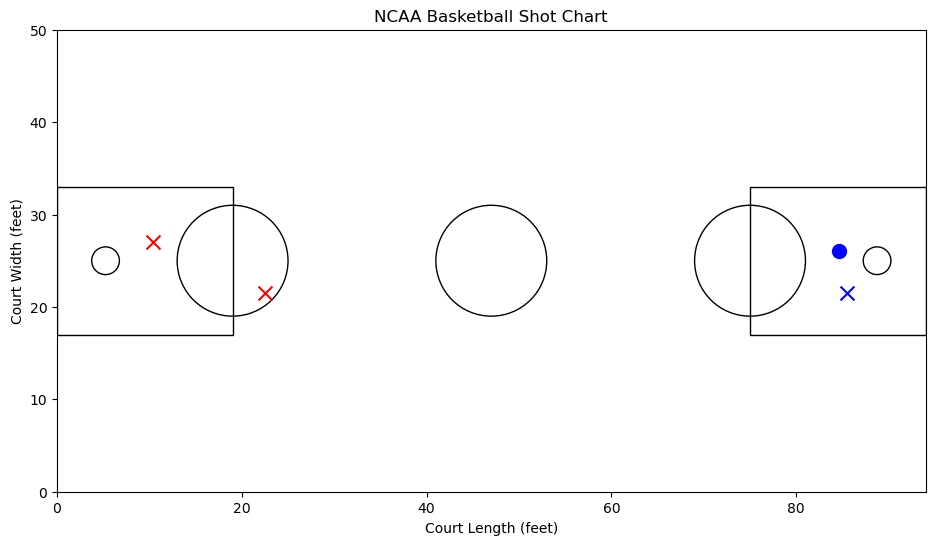

In [48]:
# Sample shot data
shot_data = [
    {
        "x": 91.0,
        "y": 43.0,
        "team_id": 157,
        "made": False,
        "player_id": 2680563039,
        "description": "1st 09:39:00 : missed by Nyamer Diew(Colorado) 0-0",
        "meta_info": "period_1 player_775989920 team_157",
        "flag": False,
    },
    {
        "x": 11.0,
        "y": 54.0,
        "team_id": 811,
        "made": False,
        "player_id": 2680563041,
        "description": "1st 09:26:00 : missed by Emily Mellema(Wyoming) 0-0",
        "meta_info": "period_1 player_775989910 team_811",
        "flag": False,
    },
    {
        "x": 90.0,
        "y": 52.0,
        "team_id": 157,
        "made": True,
        "player_id": 2680563045,
        "description": "1st 09:08:00 : made by Tabitha Betson(Colorado) 2-0",
        "meta_info": "period_1 player_775989928 team_157",
        "flag": False,
    },
    {
        "x": 24.0,
        "y": 43.0,
        "team_id": 811,
        "made": False,
        "player_id": 2680563046,
        "description": "1st 08:42:00 : missed by Emily Mellema(Wyoming) 2-0",
        "meta_info": "period_1 player_775989910 team_811",
        "flag": False,
    },
]


# Function to draw an NCAA Basketball Court
def draw_court(ax=None):
    if ax is None:
        ax = plt.gca()

    # Court dimensions
    ax.set_xlim(0, 94)
    ax.set_ylim(0, 50)

    # Paint areas
    ax.add_patch(patches.Rectangle((0, 17), 19, 16, fill=False, color="black"))
    ax.add_patch(patches.Rectangle((75, 17), 19, 16, fill=False, color="black"))

    # Hoops
    ax.add_patch(patches.Circle((5.25, 25), 1.5, fill=False, color="black"))
    ax.add_patch(patches.Circle((88.75, 25), 1.5, fill=False, color="black"))

    # Free throw circles
    ax.add_patch(patches.Circle((19, 25), 6, fill=False, color="black"))
    ax.add_patch(patches.Circle((75, 25), 6, fill=False, color="black"))

    # Center circle
    ax.add_patch(patches.Circle((47, 25), 6, fill=False, color="black"))


# Plot the court
fig, ax = plt.subplots(figsize=(12, 6))
draw_court(ax)

for shot in shot_data:
    color = "blue" if shot["team_id"] == 157 else "red"  # Different colors for teams
    marker = (
        "o" if shot["made"] else "x"
    )  # Made shots are circles, missed shots are crosses
    ax.scatter(
        shot["x"] * 94 / 100, shot["y"] * 50 / 100, color=color, marker=marker, s=100
    )

# Add title and set axis properties
plt.title("NCAA Basketball Shot Chart")
plt.xlabel("Court Length (feet)")
plt.ylabel("Court Width (feet)")
# plt.legend(loc='upper right')
plt.gca().set_aspect("equal", adjustable="box")
plt.show()